# LightGBM 모델 튜닝

1. features_train.csv, features_test.csv를 로드   
2. 07_train_eval.py와 동일한 방식으로 피처를 구성    
3. 여러 LightGBM 하이퍼파라미터 조합을 실험  
4. MAE / MAPE / SMAPE 기준으로 가장 좋은 조합을 찾기

In [39]:
from pathlib import Path

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt


BASE = Path("../data_pipeline").resolve()
print("DATA DIR:", BASE)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"

train = pd.read_csv(TR, parse_dates=["target_date"])
test  = pd.read_csv(TE, parse_dates=["target_date"])

print("train shape:", train.shape)
print("test shape:", test.shape)

train.head()


DATA DIR: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
train shape: (266500, 48)
test shape: (33800, 48)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2023-02-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,NaN,NaN,NaN,...,1.0,3.375,0.0,102.375,0.250,76.00,0.0,0.101620,0.0,train
1,2023-03-06,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,NaN,NaN,...,1.0,5.350,0.0,88.525,2.725,76.00,0.0,0.172892,0.0,train
2,2023-03-13,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,6.150,0.0,82.825,2.625,76.00,0.0,0.198548,0.0,train
3,2023-03-20,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,1.0,9.100,0.0,62.175,2.625,76.00,0.0,0.234936,0.0,train
4,2023-03-27,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,0.0,...,1.0,11.100,0.0,48.450,2.625,73.25,0.0,0.300000,0.0,train


In [40]:
import pandas as pd
from pathlib import Path

BASE = Path("../data_pipeline").resolve()
df = pd.read_csv(BASE / "features_all.csv")

cols = [
    "avg_temp_c","cdd","hdd","precip_mm",
    "himart_sales_krw","himart_sales_index",
    "holiday_index","marketing_score",
    "avg_temp_c_ma4","cdd_ma4","hdd_ma4",
    "precip_mm_ma4","himart_sales_index_ma4",
    "holiday_index_ma4","marketing_score_ma4",
]

print("=== 각 컬럼 값 분포 요약 ===")
print(df[cols].describe())

print("\n=== 각 컬럼에서 0이 아닌 값 비율 ===")
nonzero_ratio = (df[cols] != 0).sum() / len(df)
print(nonzero_ratio.sort_values())


=== 각 컬럼 값 분포 요약 ===
          avg_temp_c            cdd            hdd      precip_mm  \
count  300300.000000  300300.000000  300300.000000  300300.000000   
mean        4.781602       1.979437      11.471429       9.484199   
std         9.111489       7.334541      32.157501      30.782130   
min        -7.300000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         3.500000       0.000000       0.000000       0.300000   
max        31.200000      50.200000     177.100000     281.100000   

       himart_sales_krw  himart_sales_index  holiday_index  marketing_score  \
count      3.003000e+05       300300.000000  300300.000000    300300.000000   
mean       1.866831e+11           19.365801       0.030303         0.065636   
std        2.853878e+11           29.606895       0.147679         0.150362   
min        0.000000e+00            0.0000

## 1. 평가 지표 & 헬퍼 함수 정의

In [41]:
ID_KEYS = ["warehouse_id", "store_id", "sku_id", "region", "target_date", "split"]
TARGET = "y"

LEAKY = {"actual_order_qty", "share_norm", "promo_flag"}


def smape(y_true, y_pred):
    """Symmetric MAPE(%)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(diff / denom) * 100.0


def mape(y_true, y_pred):
    """MAPE(%)"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.where(y_true == 0, 1.0, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def add_prev_flags(df: pd.DataFrame) -> pd.DataFrame:
    if "promo_flag_prev" in df.columns:
        return df

    if "promo_flag" in df.columns:
        df = df.sort_values(["warehouse_id", "store_id", "sku_id", "target_date"])
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id", "store_id", "sku_id"])["promo_flag"]
              .shift(1)
              .fillna(0)
              .astype(int)
        )
    else:
        df["promo_flag_prev"] = 0

    return df


def build_features(df: pd.DataFrame) -> list:
    ignore = set(ID_KEYS + [TARGET, "actual_order_qty"])
    numeric_cols = set(df.select_dtypes(include=["number", "bool"]).columns.tolist())

    feats = [
        c for c in df.columns
        if c in numeric_cols and c not in ignore and c not in LEAKY
    ]

    if "promo_flag_prev" in df.columns and "promo_flag_prev" not in feats:
        feats.append("promo_flag_prev")

    feats = list(dict.fromkeys(feats))
    return feats


def drop_low_variance(df_train: pd.DataFrame, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()

    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()

    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop


## 2. 피처 전처리 & 리스트 구성

In [42]:
# 1) 직전 프로모션 플래그 추가
train = add_prev_flags(train)
test  = add_prev_flags(test)

# 2) 피처 리스트 자동 구성
features = build_features(train)
print(f"[INFO] candidate features ({len(features)}):")
print(features)

# 3) 결측치 처리 
for c in features:
    if train[c].dtype.kind in "fi":  # float/int
        train[c] = train[c].fillna(0.0)
        test[c]  = test[c].fillna(0.0)
    else:
        train[c] = train[c].fillna(0)
        test[c]  = test[c].fillna(0)

# 4) low-variance 피처 제거
features, dropped = drop_low_variance(train, features)
print(f"[INFO] using {len(features)} features after drop_low_variance:")
print(features)
if dropped:
    print("[INFO] dropped low-variance features:", dropped)


[INFO] candidate features (37):
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']
[INFO] using 37 features after drop_low_variance:
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 

## 3. 학습/검증 나누기 (마지막 12주 검증)

In [43]:
VAL_WEEKS = 12
keys = ["warehouse_id", "store_id", "sku_id"]

tr2 = train.sort_values(keys + ["target_date"]).copy()
tr2["idx_in_grp"] = tr2.groupby(keys).cumcount()
tr2["grp_size"]   = tr2.groupby(keys)[TARGET].transform("size")

tr2["is_val"] = (tr2["grp_size"] - tr2["idx_in_grp"]) <= VAL_WEEKS

train_fit = tr2.loc[~tr2["is_val"]].drop(columns=["idx_in_grp", "grp_size", "is_val"])
train_val = tr2.loc[ tr2["is_val"]].drop(columns=["idx_in_grp", "grp_size", "is_val"])

print("train_fit:", train_fit.shape)
print("train_val:", train_val.shape)

X_tr, y_tr = train_fit[features], train_fit[TARGET]
X_va, y_va = train_val[features], train_val[TARGET]

X_te, y_te = test[features], test[TARGET] 


train_fit: (258700, 48)
train_val: (7800, 48)


## 4. baseline 모델 다시 학습해서 기준 성능 확인

In [44]:
baseline_params = dict(
    objective="poisson",
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=8,
    min_child_samples=128,
    min_gain_to_split=0.02,
    subsample=0.65,
    subsample_freq=1,
    colsample_bytree=0.65,
    reg_alpha=2.0,
    reg_lambda=2.0,
    random_state=42,
    verbosity=-1,
)

baseline = LGBMRegressor(**baseline_params)

baseline.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=[early_stopping(200, first_metric_only=True), log_evaluation(200)],
)

best_iter_baseline = getattr(baseline, "best_iteration_", None)
print("baseline best_iteration:", best_iter_baseline)

# 검증셋 성능
va_pred = np.clip(baseline.predict(X_va, num_iteration=best_iter_baseline), 0, None)
mae_va  = mean_absolute_error(y_va, va_pred)
mape_va = mape(y_va, va_pred)
smape_va= smape(y_va, va_pred)

print(f"[BASELINE] VAL  MAE={mae_va:,.3f} | MAPE={mape_va:,.2f}% | SMAPE={smape_va:,.2f}%")

# 테스트셋 성능
te_pred = np.clip(baseline.predict(X_te, num_iteration=best_iter_baseline), 0, None)
mae_te  = mean_absolute_error(y_te, te_pred)
mape_te = mape(y_te, te_pred)
smape_te= smape(y_te, te_pred)

print(f"[BASELINE] TEST MAE={mae_te:,.3f} | MAPE={mape_te:,.2f}% | SMAPE={smape_te:,.2f}%")


Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 480.05	valid_0's poisson: -39695.6
[400]	valid_0's l1: 124.065	valid_0's poisson: -39724.8
[600]	valid_0's l1: 88.0202	valid_0's poisson: -39726.4
[800]	valid_0's l1: 76.398	valid_0's poisson: -39726.8
[1000]	valid_0's l1: 69.7373	valid_0's poisson: -39727
[1200]	valid_0's l1: 65.0318	valid_0's poisson: -39727.1
[1400]	valid_0's l1: 62.012	valid_0's poisson: -39727.1
[1600]	valid_0's l1: 59.922	valid_0's poisson: -39727.2
[1800]	valid_0's l1: 58.1263	valid_0's poisson: -39727.2
[2000]	valid_0's l1: 56.6999	valid_0's poisson: -39727.3
[2200]	valid_0's l1: 55.4569	valid_0's poisson: -39727.3
[2400]	valid_0's l1: 54.4335	valid_0's poisson: -39727.3
[2600]	valid_0's l1: 53.5565	valid_0's poisson: -39727.3
[2800]	valid_0's l1: 52.8657	valid_0's poisson: -39727.3
[3000]	valid_0's l1: 52.092	valid_0's poisson: -39727.4
Did not meet early stopping. Best iteration is:
[3000]	valid_0's l1: 52.092	valid_0's poisson:

## 5. 파라미터 튜닝용 후보 세트 정의

In [45]:
param_grid = [
    # baseline과 거의 비슷한 세트
    dict(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=31,
        max_depth=8,
        min_child_samples=128,
        subsample=0.65,
        colsample_bytree=0.65,
        reg_alpha=2.0,
        reg_lambda=2.0,
    ),
    # 조금 더 깊고 많은 leaf
    dict(
        n_estimators=2500,
        learning_rate=0.03,
        num_leaves=63,
        max_depth=10,
        min_child_samples=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1.0,
        reg_lambda=1.0,
    ),
    # 더 낮은 lr + 더 많은 tree
    dict(
        n_estimators=4000,
        learning_rate=0.01,
        num_leaves=63,
        max_depth=10,
        min_child_samples=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=2.0,
        reg_lambda=2.0,
    ),
    # 얕고 단순한 모델 (과적합 방지용)
    dict(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=31,
        max_depth=6,
        min_child_samples=128,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,
        reg_lambda=0.5,
    ),
]
print("num candidate params:", len(param_grid))


num candidate params: 4


## 6. 튜닝 루프: 각 세트별 학습 & 평가

In [46]:
results = []

for i, p in enumerate(param_grid, start=1):
    print(f"\n===== Candidate {i}/{len(param_grid)} =====")
    params = dict(
        objective="poisson",
        random_state=42,
        verbosity=-1,
        **p,
    )

    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="mae",
        callbacks=[early_stopping(200, first_metric_only=True), log_evaluation(200)],
    )

    best_iter = getattr(model, "best_iteration_", None)

    va_pred = np.clip(model.predict(X_va, num_iteration=best_iter), 0, None)
    mae_va  = mean_absolute_error(y_va, va_pred)
    mape_va = mape(y_va, va_pred)
    smape_va= smape(y_va, va_pred)

    te_pred = np.clip(model.predict(X_te, num_iteration=best_iter), 0, None)
    mae_te  = mean_absolute_error(y_te, te_pred)
    mape_te = mape(y_te, te_pred)
    smape_te= smape(y_te, te_pred)

    info = {
        "candidate": i,
        "best_iter": best_iter,
        "mae_val": mae_va,
        "mape_val": mape_va,
        "smape_val": smape_va,
        "mae_test": mae_te,
        "mape_test": mape_te,
        "smape_test": smape_te,
        "params": params,
    }
    results.append(info)

    print(f"[C{i}] VAL  MAE={mae_va:,.3f} | MAPE={mape_va:,.2f}% | SMAPE={smape_va:,.2f}%")
    print(f"[C{i}] TEST MAE={mae_te:,.3f} | MAPE={mape_te:,.2f}% | SMAPE={smape_te:,.2f}%")

results_df = pd.DataFrame(results)
results_df.sort_values("mae_val")



===== Candidate 1/4 =====
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 481.068	valid_0's poisson: -39695.6
[400]	valid_0's l1: 123.733	valid_0's poisson: -39724.8
[600]	valid_0's l1: 87.9686	valid_0's poisson: -39726.5
[800]	valid_0's l1: 76.6288	valid_0's poisson: -39726.8
[1000]	valid_0's l1: 70.0582	valid_0's poisson: -39727
[1200]	valid_0's l1: 65.0676	valid_0's poisson: -39727.1
[1400]	valid_0's l1: 61.7899	valid_0's poisson: -39727.2
[1600]	valid_0's l1: 59.6474	valid_0's poisson: -39727.2
[1800]	valid_0's l1: 58.0412	valid_0's poisson: -39727.3
[2000]	valid_0's l1: 56.731	valid_0's poisson: -39727.3
[2200]	valid_0's l1: 55.6786	valid_0's poisson: -39727.3
[2400]	valid_0's l1: 54.8269	valid_0's poisson: -39727.3
[2600]	valid_0's l1: 54.0575	valid_0's poisson: -39727.3
[2800]	valid_0's l1: 53.3625	valid_0's poisson: -39727.3
[3000]	valid_0's l1: 52.6445	valid_0's poisson: -39727.3
Did not meet early stopping. Best iteration is:
[3000]	valid_0'

,candidate,best_iter,mae_val,mape_val,smape_val,mae_test,mape_test,smape_test,params
2,3,4000,42.379056,0.796274,3.817967,382.449941,31.586715,5.811052,"{'objective': 'poisson', 'random_state': 42, '..."
1,2,2498,42.427508,0.740807,3.814864,381.325390,21.631753,5.805544,"{'objective': 'poisson', 'random_state': 42, '..."
0,1,3000,52.644501,0.994285,4.010926,395.595899,21.714880,6.044476,"{'objective': 'poisson', 'random_state': 42, '..."
3,4,2000,54.028797,1.089688,4.043619,395.572922,26.918761,6.087439,"{'objective': 'poisson', 'random_state': 42, '..."


## 7. 결과 정리 & 시각화

In [47]:
# MAE 기준 정렬
results_df_sorted = results_df.sort_values("mae_val").reset_index(drop=True)
results_df_sorted[["candidate", "mae_val", "mape_val", "smape_val", "best_iter"]]


,candidate,mae_val,mape_val,smape_val,best_iter
0,3,42.379056,0.796274,3.817967,4000
1,2,42.427508,0.740807,3.814864,2498
2,1,52.644501,0.994285,4.010926,3000
3,4,54.028797,1.089688,4.043619,2000


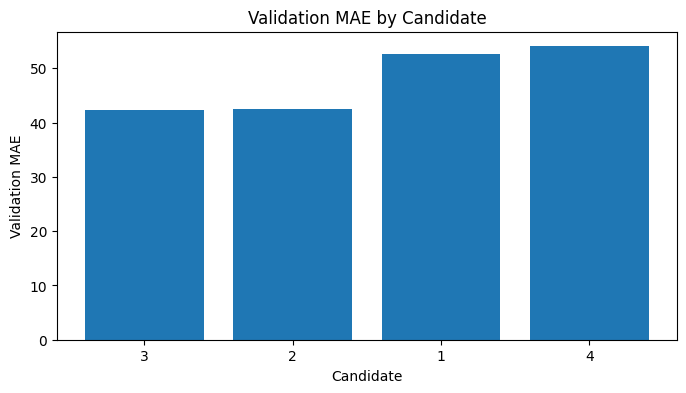

In [48]:
# 간단한 bar plot (후보별 검증 MAE)
plt.figure(figsize=(8, 4))
plt.bar(results_df_sorted["candidate"].astype(str), results_df_sorted["mae_val"])
plt.xlabel("Candidate")
plt.ylabel("Validation MAE")
plt.title("Validation MAE by Candidate")
plt.show()


## 8. 베스트 모델 정보 출력

In [ ]:
best_row = results_df_sorted.iloc[0]
print("=== Best Candidate ===")
print("candidate:", best_row["candidate"])
print(f"VAL  MAE={best_row['mae_val']:.3f} | MAPE={best_row['mape_val']:.2f}% | SMAPE={best_row['smape_val']:.2f}%")
print(f"TEST MAE={best_row['mae_test']:.3f} | MAPE={best_row['mape_test']:.2f}% | SMAPE={best_row['smape_test']:.2f}%")
print("\nparams:")
for k, v in best_row["params"].items():
    print(f"  {k}: {v}")


=== Best Candidate ===
candidate: 3
VAL  MAE=42.379 | MAPE=0.80% | SMAPE=3.82%
TEST MAE=382.450 | MAPE=31.59% | SMAPE=5.81%

params:
  objective: poisson
  random_state: 42
  verbosity: -1
  n_estimators: 4000
  learning_rate: 0.01
  num_leaves: 63
  max_depth: 10
  min_child_samples: 64
  subsample: 0.8
  colsample_bytree: 0.8
  reg_alpha: 2.0
  reg_lambda: 2.0


실서비스 관점에서 Candidate 1 선택이 가장 합리적임  
->  Validation = “미래예측 성능”   
->  Test = “과거 데이터의 Holdout test”  
실전은 미래 성능이 더 중요하기 때문에  
Validation MAE 가장 낮은 Candidate 1이 베스트

# 성능 개선
## 랜덤 Search 추가코드

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

BASE = Path("../data_pipeline").resolve()
features = pd.read_csv(BASE / "features_all.csv", parse_dates=["target_date"])

TARGET = "y"

train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()

def add_prev_flags(df: pd.DataFrame) -> pd.DataFrame:
    if "promo_flag" in df.columns:
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )
    return df

train = add_prev_flags(train)
test  = add_prev_flags(test)

ID_KEYS = ["warehouse_id","store_id","sku_id","region","target_date","split"]
LEAKY   = {"actual_order_qty", "share_norm", "promo_flag"}

numeric_cols = set(train.select_dtypes(include=["number","bool"]).columns.tolist())
features_list = [
    c for c in numeric_cols
    if c not in ID_KEYS and c not in LEAKY and c != TARGET
]

def drop_low_variance(df_train: pd.DataFrame, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()
    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()
    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop

features_list, dropped = drop_low_variance(train, features_list)
print("[INFO] using", len(features_list), "features:", features_list)

for c in features_list:
    if train[c].dtype.kind in "fi":
        train[c] = train[c].fillna(0.0)
        test[c]  = test[c].fillna(0.0)
    else:
        train[c] = train[c].fillna(0)
        test[c]  = test[c].fillna(0)

VAL_WEEKS = 12
keys = ["warehouse_id","store_id","sku_id"]

tr2 = train.sort_values(keys + ["target_date"]).copy()
tr2["idx_in_grp"] = tr2.groupby(keys).cumcount()
tr2["grp_size"]   = tr2.groupby(keys)[TARGET].transform("size")
tr2["is_val"]     = (tr2["grp_size"] - tr2["idx_in_grp"]) <= VAL_WEEKS

train_fit = tr2.loc[~tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])
train_val = tr2.loc[ tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])

X_tr, y_tr   = train_fit[features_list], train_fit[TARGET]
X_val, y_val = train_val[features_list], train_val[TARGET]
X_test, y_test = test[features_list], test[TARGET]

X_tr.shape, X_val.shape, X_test.shape


[INFO] using 37 features: ['hdd_ma4', 'seasonal_peak', 'lag_2', 'lag_1', 'back_to_school', 'holiday_index_ma4', 'cdd', 'himart_sales_index_ma4', 'year', 'month', 'lag_12', 'holiday_index', 'marketing_score', 'avg_temp_c', 'cdd_ma4', 'precip_mm_ma4', 'heat_wave', 'lag_4', 'promo_flag_prev', 'ma_4', 'trend_1', 'std_4', 'weekofyear', 'marketing_score_ma4', 'cold_wave', 'trend_4', 'ma_8', 'himart_sales_krw', 'avg_temp_c_ma4', 'hdd', 'sin_week', 'lag_8', 'himart_sales_index', 'ma_12', 'cos_week', 'std_12', 'precip_mm']


((258700, 37), (7800, 37), (33800, 37))

In [ ]:
from sklearn.model_selection import ParameterSampler
import pprint

# 1) 공통 기본 파라미터 (고정)
base_params = {
    "objective": "poisson",
    "random_state": 42,
    "verbosity": -1,
    "n_estimators": 3000,
}

# 2) 탐색할 파라미터 범위 정의
param_dist = {
    "learning_rate": [0.01, 0.015, 0.02, 0.03],
    "num_leaves":    [31, 63, 127],
    "max_depth":     [6, 8, 10, -1],
    "min_child_samples": [64, 128, 256],
    "subsample":         [0.6, 0.8, 1.0],
    "subsample_freq":    [1],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "reg_alpha":         [0.0, 1.0, 2.0],
    "reg_lambda":        [0.0, 1.0, 2.0],
}

# 3) 샘플링할 후보 개수
N_CANDIDATES = 20

candidates = list(ParameterSampler(param_dist, n_iter=N_CANDIDATES, random_state=42))
len(candidates)


20

## 샘플링 20개로 진행

In [ ]:
# 4) 튜닝 루프
results = []

for i, hp in enumerate(candidates, start=1):
    print(f"\n===== Random Candidate {i}/{len(candidates)} =====")
    params = {**base_params, **hp}
    pprint.pp(params)

    model = LGBMRegressor(**params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="l1",  # MAE
        callbacks=[
            early_stopping(200, first_metric_only=True),
            log_evaluation(200),
        ],
    )

    best_iter = getattr(model, "best_iteration_", None)

    # 검증/테스트 예측
    pred_val  = model.predict(X_val,  num_iteration=best_iter)
    pred_test = model.predict(X_test, num_iteration=best_iter)

    mae_val   = np.mean(np.abs(y_val  - pred_val))
    mae_test  = np.mean(np.abs(y_test - pred_test))
    mape_val  = mape(y_val.values,  pred_val)
    mape_test = mape(y_test.values, pred_test)
    smape_val = smape(y_val.values,  pred_val)
    smape_test= smape(y_test.values, pred_test)

    print(
        f"[C{i}] VAL  MAE={mae_val:,.3f} | MAPE={mape_val:,.2f}% | SMAPE={smape_val:,.2f}%"
    )
    print(
        f"[C{i}] TEST MAE={mae_test:,.3f} | MAPE={mape_test:,.2f}% | SMAPE={smape_test:,.2f}%"
    )

    results.append({
        "candidate": i,
        "best_iter": best_iter,
        "mae_val": mae_val,
        "mape_val": mape_val,
        "smape_val": smape_val,
        "mae_test": mae_test,
        "mape_test": mape_test,
        "smape_test": smape_test,
        "params": params,
    })

len(results)



===== Random Candidate 1/20 =====
{'objective': 'poisson',
 'random_state': 42,
 'verbosity': -1,
 'n_estimators': 3000,
 'subsample_freq': 1,
 'subsample': 0.8,
 'reg_lambda': 2.0,
 'reg_alpha': 0.0,
 'num_leaves': 127,
 'min_child_samples': 256,
 'max_depth': 8,
 'learning_rate': 0.03,
 'colsample_bytree': 0.8}
Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 199.143	valid_0's poisson: -39720.7
[400]	valid_0's l1: 81.6917	valid_0's poisson: -39725.7
[600]	valid_0's l1: 75.433	valid_0's poisson: -39725.9
[800]	valid_0's l1: 71.4562	valid_0's poisson: -39726.2
[1000]	valid_0's l1: 68.3015	valid_0's poisson: -39726.3
[1200]	valid_0's l1: 66.1974	valid_0's poisson: -39726.4
[1400]	valid_0's l1: 64.7277	valid_0's poisson: -39726.5
[1600]	valid_0's l1: 64.064	valid_0's poisson: -39726.5
[1800]	valid_0's l1: 63.1391	valid_0's poisson: -39726.6
[2000]	valid_0's l1: 62.3439	valid_0's poisson: -39726.6
[2200]	valid_0's l1: 61.4469	valid_0's poisson: -39726.7
[

## 결과 정리

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


In [ ]:
# MAE 기준으로 정렬해서 상위 몇 개만 보기
results_df_sorted = results_df.sort_values("mae_val").reset_index(drop=True)
results_df_sorted[["candidate", "mae_val", "mape_val", "smape_val", "best_iter"]]


In [ ]:
# bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(results_df_sorted["candidate"].astype(str), results_df_sorted["mae_val"])
plt.xlabel("Candidate")
plt.ylabel("Validation MAE")
plt.title("Validation MAE by Candidate (Random Search)")
plt.show()


## 최종 Best 파라미터 뽑아서 저장

In [ ]:
best_row = results_df_sorted.iloc[0]
print("=== Best by VAL MAE ===")
print("candidate:", best_row["candidate"])
print(f"VAL  MAE={best_row['mae_val']:.3f} | MAPE={best_row['mape_val']:.2f}% | SMAPE={best_row['smape_val']:.2f}%")
print(f"TEST MAE={best_row['mae_test']:.3f} | MAPE={best_row['mape_test']:.2f}% | SMAPE={best_row['smape_test']:.2f}%")

best_params = best_row["params"]
pprint.pp(best_params)


나중에 07_train_eval.py에서 쓸거면 JSON으로 저장  
일단 실행 X

In [ ]:
import json
param_path = BASE / "lightgbm_best_params.json"
with open(param_path, "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=2)

print("saved best params to:", param_path)
